In [2]:
from tokenizers import Tokenizer
from tokenizers.models import BPE,WordPiece,Unigram
from tokenizers.pre_tokenizers import Whitespace
from tokenizers.trainers import BpeTrainer,WordPieceTrainer, UnigramTrainer

In [4]:
class Options:
    def __init__(self, name) -> None:
        self.name= name
    def name(self):
        return self.name
options = Options("Model")
options.SOS = 0 # start of sentence
options.EOS = 1 # End of sentence
options.PAD = 2 # padding token
options.UNK = 3 # unknown token, word frequency low
class Vocab:
    def __init__(self, name):
        self.name = name
        self.word2index = {"<sos>":options.SOS, "<eos>":options.EOS, "<pad>":options.PAD,"<unk>":options.UNK}
        self.word2count = {"<sos>":1, "<eos>":1, "<pad>":1,"<unk>":1}
        self.index2word = {options.SOS: "<sos>", options.EOS: "<eos>", options.PAD:"<pad>",options.UNK: "<unk>"}
        self.n_words = 4  # Count PAD , SOS and EOS
        self.feature_max = [] # max value of feature
        self.feature_min = [] # min value of feature
        self.line_max = 0 # max length of sentence

    def addTokens(self, tokens):
        for word in tokens:
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [ ]:
from transformers import AutoTokenizer
import numpy as np
from datasets import load_dataset,load_from_disk

def gen_token_features(tokens, vocab):
    tok_len = len(tokens)
    features= np.empty([tok_len, 2])
    for i in range(tok_len):
        token = tokens[i]
        size = len(token)
        count = vocab.word2count[token]
        features[i] = [size, count]
    return features

dataset_path = "/home/yang/github/fuzzys2s/output/wmt14/fr-en/"
dataset = load_from_disk(dataset_path)
train_len = dataset['train'].num_rows
train_iter = iter(dataset['train'])
tokenizer_path = "/home/yang/github/fuzzys2s/output/bert-base-uncased/"
tokenizer = AutoTokenizer.from_pretrained(tokenizer_path)
vocab = Vocab('wmt14')
for i in range(train_len):
    data = next(train_iter)
    de = data['translation']['de']
    en = data['translation']['en']
    raw_line =  en + ' ' + de
    tokens = tokenizer.tokenize(raw_line)
    vocab.addTokens(tokens)
    


In [3]:
from transformers import AutoTokenizer
import numpy as np
from datasets import load_dataset
dataset = load_dataset("wmt16",'de-en')
dataset = dataset.shuffle()
# print(dataset['train'])
train_len = dataset['train'].num_rows
train_iter = iter(dataset['train'])
raw_line = np.empty(train_len).tolist()
for i in range(train_len):
    data = next(train_iter)
    de = data['translation']['de']
    en = data['translation']['en']
    raw_line[i] =  en + ' ' + de

Found cached dataset wmt16 (/home/yang/.cache/huggingface/datasets/wmt16/de-en/1.0.0/746749a11d25c02058042da7502d973ff410e73457f3d305fc1177dc0e8c4227)


  0%|          | 0/3 [00:00<?, ?it/s]

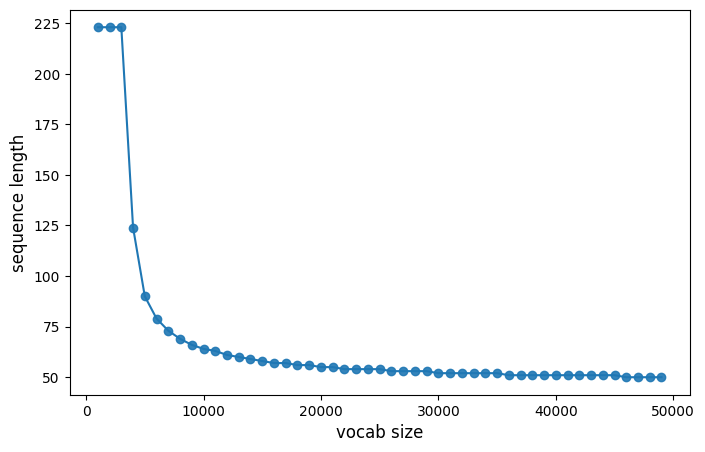

In [4]:
from matplotlib import pyplot as plt
import os

def train_tokenizer(raw_lines, vocab_size, dataset):
    tokenizer_path = "../output/tokenizers/vs"+str(vocab_size)+"_"+dataset+"_tokenizer"
    if os.path.exists(tokenizer_path):
        tokenizer = AutoTokenizer.from_pretrained(tokenizer_path)
    else:
        tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
        tokenizer = tokenizer.train_new_from_iterator(raw_lines, vocab_size=vocab_size)
        tokenizer.save_pretrained(tokenizer_path)
    slen = 0
    snum = 100
    count = 0
    for line in raw_line[:snum]:
        if len(line) >= 512:
            continue
        count = count + 1
        tokens = tokenizer.tokenize(line)
        slen = slen + len(tokens)
    return vocab_size, int(slen/count)

tok_num = 50
tok_par = 1000
tok_data= np.empty((tok_num,2))
for i in range(tok_num):
    if i <= 0:
        continue
    vs, tlen = train_tokenizer(raw_line, i*tok_par, "wmt16 de-en")
    tok_data[i][0] = vs
    tok_data[i][1] = tlen

plt.figure(figsize=(8, 5))
plt.scatter(tok_data[1:,0], tok_data[1:,1], alpha=.9)
plt.plot(tok_data[1:,0], tok_data[1:,1])
plt.xlabel("vocab size", size=12)
plt.ylabel("sequence length", size=12)
plt.show()

In [32]:
vs1000_tokenizer = AutoTokenizer.from_pretrained("../output/vs1000_tokenizer/")
vs2000_tokenizer = AutoTokenizer.from_pretrained("../output/vs2000_tokenizer/")
vs5000_tokenizer = AutoTokenizer.from_pretrained("../output/vs5000_tokenizer/")
vs10000_tokenizer = AutoTokenizer.from_pretrained("../output/vs10000_tokenizer/")
vs20000_tokenizer = AutoTokenizer.from_pretrained("../output/vs20000_tokenizer/")
vs50000_tokenizer = AutoTokenizer.from_pretrained("../output/vs50000_tokenizer/")
print("vocab size=1000 tokenizer")
line = raw_line[10]
print(line)
tokens = vs1000_tokenizer.tokenize(line)
print('[vs1000] ',str(len(tokens)))
tokens = vs2000_tokenizer.tokenize(line)
print('[vs2000] ',str(len(tokens)))
tokens = vs5000_tokenizer.tokenize(line)
print('[vs5000] ',str(len(tokens)))
tokens = vs10000_tokenizer.tokenize(line)
print('[vs10000] ',str(len(tokens)))
tokens = vs20000_tokenizer.tokenize(line)
print('[vs20000] ',str(len(tokens)))
tokens = vs50000_tokenizer.tokenize(line)
print('[vs50000] ',str(len(tokens)))

vocab size=1000 tokenizer
After the very successful cooperation with german Hip Hop artist Samy Deluxe and the female race driver Kati Droste, the german artist Clueso will become the new vigozone - agent. Six Step war verantwortlich für die Auswahl und betreut Clueso auch im weiteren Verlauf der diesjährigen vigozone Kampagne.
[vs1000]  256
[vs2000]  256
[vs5000]  111
[vs10000]  80
[vs20000]  65
[vs50000]  59
